In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [50]:
plt.style.use("fivethirtyeight")

In [2]:
IMAGE_SHAPE = (256, 256)
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


# Exploring Images

## Getting class names

In [4]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

## Showing 10 images

(32, 256, 256, 3)
tf.Tensor([1 0 0 0 0 2 1 1 0 2 2 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0], shape=(32,), dtype=int32)


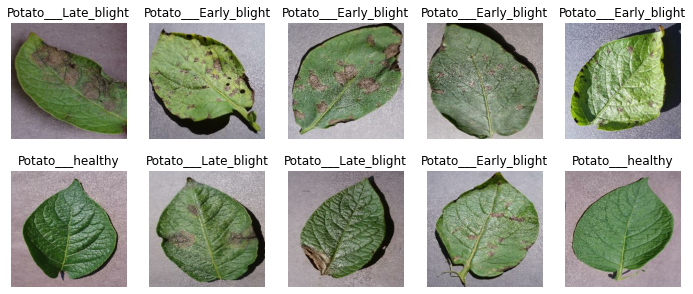

In [5]:
plt.figure(figsize=(12, 5))

for image_batch, label_batch in dataset.take(1):

    print(image_batch.shape)
    print(label_batch)

    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis(False)

# Preparing Data

## Splitting

In [6]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10_000):
    dataset_size = len(ds)

    # Calculating number of batch samples to take for each dataset
    train_dataset_size = round(dataset_size * train_split)
    val_dataset_size = round(val_split * len(dataset))
    test_dataset_size = round(test_split * len(dataset))

    # Getting training data from dataset
    train_data = dataset.take(train_dataset_size)

    # Getting validation and testing data from batch
    temp_data = dataset.skip(train_dataset_size)
    val_data = temp_data.take(val_dataset_size)
    test_data = temp_data.skip(val_dataset_size).take(test_dataset_size)

    if shuffle:
        train_data = train_data.cache().shuffle(shuffle_size).prefetch(buffer_size=tf.data.AUTOTUNE)
        val_data = val_data.cache().shuffle(shuffle_size).prefetch(buffer_size=tf.data.AUTOTUNE)
        test_data = test_data.cache().shuffle(shuffle_size).prefetch(buffer_size=tf.data.AUTOTUNE)
        print("Dataset cached.")

    print(f"Splitted dataset with length {dataset_size} into {train_dataset_size} Training Data, {val_dataset_size} Validation Data, {test_dataset_size} Test Data.")

    return train_data, val_data, test_data

In [7]:
train_data, val_data, test_data = split_dataset(dataset)

Dataset cached.
Splitted dataset with length 68 into 54 Training Data, 7 Validation Data, 7 Test Data.


## Preprocessing

In [8]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

# Data Augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Training

In [17]:
TRAINING_EPOCHS = 10
CHANNELS = 3
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SHAPE[0], IMAGE_SHAPE[1], CHANNELS)
N_CLASSES = len(dataset.class_names)

In [18]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(N_CLASSES, activation="softmax"),
])

model.build(input_shape=INPUT_SHAPE)

In [19]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [20]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [21]:
%%time

history = model.fit(
    train_data,
    epochs=TRAINING_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_data,
)

Epoch 1/10
54/54 [==============================] - 62s 1s/step - loss: 0.8204 - accuracy: 0.5666 - val_loss: 0.5926 - val_accuracy: 0.7366
Epoch 2/10
54/54 [==============================] - 58s 1s/step - loss: 0.4047 - accuracy: 0.8414 - val_loss: 0.4386 - val_accuracy: 0.8170
Epoch 3/10
54/54 [==============================] - 59s 1s/step - loss: 0.2920 - accuracy: 0.8877 - val_loss: 0.4501 - val_accuracy: 0.8839
Epoch 4/10
54/54 [==============================] - 57s 1s/step - loss: 0.2497 - accuracy: 0.9034 - val_loss: 0.2486 - val_accuracy: 0.8839
Epoch 5/10
54/54 [==============================] - 58s 1s/step - loss: 0.1900 - accuracy: 0.9207 - val_loss: 0.2840 - val_accuracy: 0.9062
Epoch 6/10
54/54 [==============================] - 55s 1s/step - loss: 0.1561 - accuracy: 0.9439 - val_loss: 0.2309 - val_accuracy: 0.9152
Epoch 7/10
54/54 [==============================] - 55s 1s/step - loss: 0.1839 - accuracy: 0.9265 - val_loss: 0.1778 - val_accuracy: 0.9554
Epoch 8/10
54/54 [==

# Evaluating model

<ipython-input-56-7c472c4e8578>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


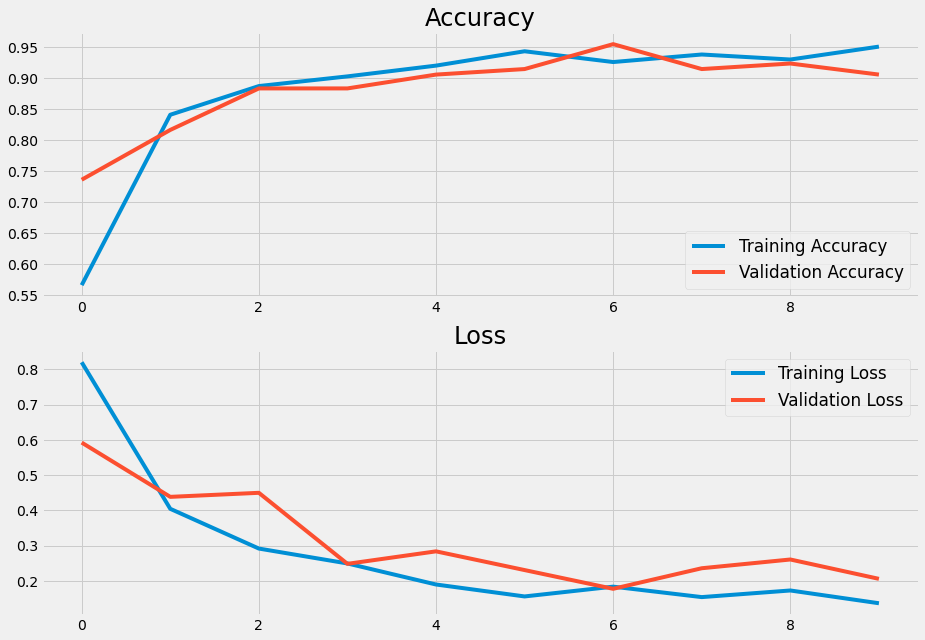

In [56]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14,10))

ax1.plot(history.history["accuracy"], label="Training Accuracy")
ax1.plot(history.history["val_accuracy"], label="Validation Accuracy")
ax1.set_title("Accuracy", fontdict={"fontsize": "xx-large"})
ax1.legend(loc="lower right", fontsize="large")

ax2.plot(history.history["loss"], label="Training Loss")
ax2.plot(history.history["val_loss"], label="Validation Loss")
ax2.set_title("Loss", fontdict={"fontsize": "xx-large"})
ax2.legend(loc="upper right", fontsize="large")

fig.show();

In [54]:
scores = model.evaluate(test_data)

7/7 [==============================] - 1s 163ms/step - loss: 0.1774 - accuracy: 0.9250
Loss: 0.1773909330368042
Accuracy: 0.925000011920929


In [55]:
print(f"Loss: {scores[0]}\nAccuracy: {scores[1]}")

Loss: 0.1773909330368042
Accuracy: 0.925000011920929


# Exporting Model

In [57]:
MODEL_VERSION = 1

model.save(f"./models/{MODEL_VERSION}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
